In [1]:
import sys
sys.path.append('../scripts')  
from models import *
from df_handling import *
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import warnings
import statistics
from sklearn.decomposition import PCA
warnings.filterwarnings("ignore")


In [2]:
#importing the datasets we want to test (you can change the dataframes you want to load accordingly)
greek = pd.read_csv('../data/greek_par_emb.csv')
greek = unravel_df(greek, ['text_embedding_claim', 'text_embedding_par'])
cyprus = pd.read_csv('../data/cyprus_par_emb.csv')
cyprus = unravel_df(cyprus, ['text_embedding_claim','text_embedding_par'])
check4facts = pd.read_csv('../data/check4facts_par_emb.csv')
check4facts = unravel_df(check4facts, ['text_embedding_claim','text_embedding_par'])
#aggregating the claim id for each dataset
check4facts['claim_id'] += int(greek['claim_id'].iloc[-1]) +1
cyprus['claim_id'] += int(check4facts['claim_id'].iloc[-1]) +1
# #creating source labels for each dataset (optionally, not necessary for the classification)
# temp_df = pd.read_csv('../data/greek_web_scraping.csv')
# temp_df['source'] = temp_df['url'].apply(lambda x: 0 if "ellinikahoaxes" in x else (1 if "factcheckgreek" in x else None))
# greek1 = pd.merge(greek1, temp_df[['id','source', 'claim']], on='claim', how='inner')
# cyprus1['source'] = 3
# check4facts1['source'] = 2

#finally we create the dataframe that the model will be trained on (you can also change this accordingly)
df_train = pd.concat([greek,check4facts,cyprus], ignore_index=True)
df_train = df_train[df_train.label<=1]
df_train.reset_index(drop=True, inplace=True)


Model Accuracy: 0.845

Model Recall: 0.826

Model Precision: 0.888

Model F1-Score: 0.855

Cross validation score: [0.823 0.855 0.806 0.855 0.823 0.839 0.803 0.918 0.836 0.885]

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83        69
           1       0.89      0.83      0.86        86

    accuracy                           0.85       155
   macro avg       0.84      0.85      0.84       155
weighted avg       0.85      0.85      0.85       155




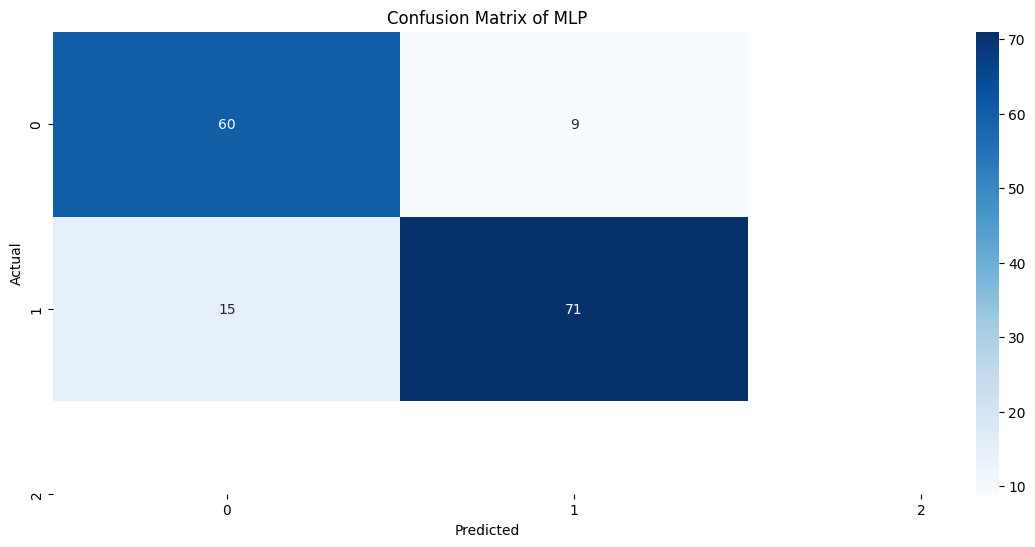

In [3]:
#create the list for the holding the training vectors (claim plus n*paragraphs)
combined_array = list()
#create a list holding the classification label
label = list()
#for each unique claim id 
for i in df_train.claim_id.unique():
    #create a temp df holding information about a specific claim_id
    df = df_train[df_train.claim_id==i]
    try:
        # display(df)
        #store the claim embedding
        claim=np.array(df.iloc[0,8])
        #store the label
        label.append(df.iloc[0,9])
    except IndexError:
        continue
    # for each paragraph related to the claim
    par = []
    for j in range(len(df)):
        #concatenate all the paragraphs together
        par = np.concatenate([par,df.iloc[j,10]])
    #finally concatenate the related paragraphs with the claim
    claim = np.concatenate([claim, par])
    #store the final vector on an array
    combined_array.append(claim)
    

#we rearrange the combined array into an array format
arr = [combined_array[i] for i in range(len(combined_array))]

#make the train test split based on the previous arrays
X_train, X_test, y_train, y_test= train_test_split(arr  ,np.array(label).astype('int'), test_size=0.2, random_state=42)

#PCA feature reduction (optional)

# X_train_scaled, X_test_scaled = list(),list()

# for x_train in X_train:
#     x_train = np.array(x_train, dtype=np.float64)
#     x_train = x_train.reshape(1536, 3) # the format is transformed into a 1536shaped vector. The second number in a tuple is equal to 
#     pca = PCA(n_components = 1)        # the number of extra paragraphs plus one. In this example we have 2 extra pars plus one
#     X_train_scaled.append(pca.fit_transform(x_train))
    
# for x_test in X_test:
#     x_test = np.array(x_test, dtype=np.float64)
#     x_test = x_test.reshape(1536, 2)
#     pca = PCA(n_components = 1) 
#     X_test_scaled.append(pca.fit_transform(x_test))

#default classification
MLP(X_train, X_test, y_train, y_test)


#classification using the pca technique
#MLP(np.array(X_train_scaled).squeeze(), np.array(X_test_scaled).squeeze(), y_train, y_test)